<a href="https://colab.research.google.com/github/OzzyWL/RNN_Predictons/blob/master/RNN_Predictions_OZ_WILSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# type of Keras losses see- https://keras.io/losses/
from tensorflow.python.keras.losses import mean_absolute_error, mean_squared_error

# For candle sticks charts
# !pip install plotly 
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
plotly.tools.set_credentials_file(username='ozzy333', 
                                  api_key='8HutzDim99yLCfKtdRmp')

from datetime import datetime

# PyDrive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# PyDrive

# Drive REST API
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
# Drive REST API

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Authenticate and create the PyDrive client.

# For Upload the file to Drive
from googleapiclient.http import MediaFileUpload

# For Downloading data from a Drive file into Python
from googleapiclient.http import MediaIoBaseDownload

print('All libaries loaded and Authentication DONE(If no errors shown)!')

All libaries loaded and Authentication DONE(If no errors shown)!


# Get data
5 years historical Tesla, Inc. (TSLA) stock price.
Downloaded from:
1) https://finance.yahoo.com/quote/TSLA/history?period1=1277762400&period2=1551481200&interval=1d&filter=history&frequency=1d

Uploaded to my drive to get unique ID.

In [0]:
#function that loads csv data from drive to pandas format

def load_data_from_drive(file_id):
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, done = downloader.next_chunk()

  # VERY Important - need to reset the buffer position to the beginning
  downloaded.seek(0) 

  file_bytes = np.asarray(bytearray(downloaded.read()))

  df = pd.read_csv(io.BytesIO(file_bytes))
  
  return df, downloader

In [0]:
# which data do I want
# for first run take 5 years of dinancial and stock prices
#TSLA
price_vol_id = '1kYwxraiYlMw6Tthi91F-tE3IpzbvoOeN'
# financial_info_id = '1AbiaS3C8mRVmzJxD4JklqknanoteMziy'
loaded_ticker = 'TSLA'

# #NVDA
# price_vol_id = '1Ld5oMoTVXp8CShdLbcpePSPbd_PouQq_'
# loaded_ticker = 'NVDA'

# loaded_ticker 
# make sure to treat unavailable data or disregard it
df_price_vol, fff = load_data_from_drive(price_vol_id)
# df_financial_info = load_data_from_drive(financial_info_id)

Extract data from pandas to plotly so I can draw a Candlestick chart.

In [0]:
# Check loaded data is OK and that plotly is working fine
trace = go.Candlestick(x=df_price_vol['Date'],
                open=df_price_vol['Open'],
                high=df_price_vol['High'],
                low=df_price_vol['Low'],
                close=df_price_vol['Close'])
data = [trace]
py.iplot(data, filename='simple_candlestick')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ozzy333/0 or inside your plot.ly account where it is named 'simple_candlestick'


#Set  hyper paramaters (TODO: hyperparams with sklearn bayesian optimisation)

In [0]:
# days I want to infer data to future
days_for_pred = 5

# shift X days so FIRST data elements are gone 
# and last data is not available ("the future")
shift_val = 10

# % to set for training data 
train_split = 0.9

# For model which is only one GRU layer and one Dense layer
batch_size = 256

# the amount of data period taken for each random batch of data in generator
sequence_length = 20 

# The number of units in the GRU cell
GRU_units = 512

learning_rate = 1e-3

# need to import from Keras wanted loss here
net_loss = mean_squared_error

net_epochs = 20
net_steps_per_epoch = 100

#Setting up Data#

Most helpful link to get started:
https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html


In [0]:
# ignore date which is a string and just get index to imply sequence of date
# also adj close in same as close it seems

# target_names = ['Open', 'Close','High', 'Low', 'Volume']
target_names = ['Open', 'Close','High', 'Low']

df_full = df_price_vol.loc[:, target_names]

# This is actually the future of LAST days wanted to predict
pred_df = df_full.tail(days_for_pred) 
pred_data = pred_df.values
# print(pred_data)

# only AFTER I extracted the predicted days wanted for inference can I shift
# cells to past VS "future" 
df = df_full[0:-days_for_pred]
# print(df)

df_future = df.shift(-shift_val)
# print(df_future)

# convert panda to numpy array data values
past_data = df.values[0:-shift_val]
# print(past_data[-7:])

future_data = df_future.values[0:-shift_val]
# print(future_data[-7:])

num_train = int(train_split * len(past_data))
# print(num_train)

num_to_last = len(past_data) - num_train
# print(num_to_last)

# for now just get most recent data as test set!
past_data_train = past_data[0:num_train]
past_data_test = past_data[num_train:]

future_data_train = future_data[0:num_train]
future_data_test = future_data[num_train:]

# print(past_data_test[-7:])
# print(future_data_test[-7:])

# print("The input size I need for the Network is:", future_data_test.shape)

# print("Meaning I need data for", past_data_test.shape[0], 
#       " of days in past (shifted) before current day")

# make output and input number the same
input_num = future_data.shape[1]
output_num = future_data.shape[1]

# print(input_num)
# print(output_num)

# Scale Data
# data_scaler = MinMaxScaler()

# # for inference only data without no GT
infer_scaler = MinMaxScaler()
pred_data_infer_scaled = infer_scaler.fit_transform(pred_data)

past_scaler= MinMaxScaler()
past_data_test_scaled = past_scaler.fit_transform(past_data_test)
past_data_train_scaled = past_scaler.fit_transform(past_data_train)


future_scaler= MinMaxScaler()
future_data_train_scaled = future_scaler.fit_transform(future_data_train)
future_data_test_scaled = future_scaler.fit_transform(future_data_test)


# print("Min:", np.min(past_data_test_scaled))
# print("Max:", np.max(past_data_test_scaled))

# print("Min:", np.min(future_data_test_scaled))
# print("Max:", np.max(future_data_test_scaled))



##Keras Implementation##
Based on: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

**Create data Generator for Keras:**

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, input_num)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, output_num)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = past_data_train_scaled[idx:idx+sequence_length]
            y_batch[i] = future_data_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

x_batch, y_batch = next(generator)


# verify
# print(x_batch.shape)
# print(y_batch.shape)
# batch = 0  
# signal = 0
# seq = x_batch[batch, :, signal]
# plt.figure(figsize=(15,5))
# plt.plot(seq)

# seq = y_batch[batch, :, signal]
# plt.figure(figsize=(15,5))
# plt.plot(seq)

**Set data for Testing / Validation**

In [0]:
#expand test/validation data to be as 1 batch with expand_dims for Keras

validation_data = (np.expand_dims(past_data_test_scaled, axis=0),
                   np.expand_dims(future_data_test_scaled, axis=0))


##  Creating model 


In [0]:
model = Sequential()

model.add(GRU(units=GRU_units,
              return_sequences=True,
              input_shape=(None, input_num,)))

model.add(Dense(output_num, activation='sigmoid')) 
# squashes to range of 0 to 1. 
# this is a problem if stock goes beyond bounderies of historical price!!!!
model.summary()

optimizer = RMSprop(lr=learning_rate)
model.compile(loss=net_loss, optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         794112    
_________________________________________________________________
dense_1 (Dense)              (None, None, 4)           2052      
Total params: 796,164
Trainable params: 796,164
Non-trainable params: 0
_________________________________________________________________


**Load previously save checkpoint:**

In [0]:
# try:
#     model.load_weights(path_checkpoint)
# except Exception as error:
#     print("Error trying to load checkpoint.")
#     print(error)

**Add call backs for Keras**

In [0]:
path_checkpoint =  'pred_' + loaded_ticker + '_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./pred_' 
                                   + loaded_ticker +'_tb_log/',
                                   histogram_freq=0,
                                   write_graph=False)


callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard]

**Compile Model:**

In [0]:
model.fit_generator(generator=generator,
                    epochs=net_epochs,
                    steps_per_epoch=net_steps_per_epoch,
                    validation_data=validation_data,
                    callbacks=callbacks)

result = model.evaluate(x=np.expand_dims(past_data_test_scaled, axis=0),
                        y=np.expand_dims(future_data_test_scaled, axis=0))
print("loss on test/validation):", result)


Epoch 1/20
1/1 [==============================] - 0s 150ms/sample - loss: 0.0761

Epoch 00001: val_loss improved from inf to 0.07607, saving model to pred_TSLA_checkpoint.keras
100/100 [==============================] - 7s 69ms/step - loss: 0.0180 - val_loss: 0.0761
Epoch 2/20
1/1 [==============================] - 0s 42ms/sample - loss: 0.0686

Epoch 00002: val_loss improved from 0.07607 to 0.06864, saving model to pred_TSLA_checkpoint.keras
100/100 [==============================] - 6s 60ms/step - loss: 0.0085 - val_loss: 0.0686
Epoch 3/20
1/1 [==============================] - 0s 44ms/sample - loss: 0.0658

Epoch 00003: val_loss improved from 0.06864 to 0.06580, saving model to pred_TSLA_checkpoint.keras
100/100 [==============================] - 6s 59ms/step - loss: 0.0073 - val_loss: 0.0658
Epoch 4/20
1/1 [==============================] - 0s 43ms/sample - loss: 0.0648

Epoch 00004: val_loss improved from 0.06580 to 0.06479, saving model to pred_TSLA_checkpoint.keras
100/100 [====

**Results:**

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = past_data_train_scaled
        y_true = past_data_train
        data_scaler = past_scaler
    else:
        # Use test-data.
        x = future_data_test_scaled
        y_true = future_data_test
        data_scaler = future_scaler
        
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = data_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')

        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

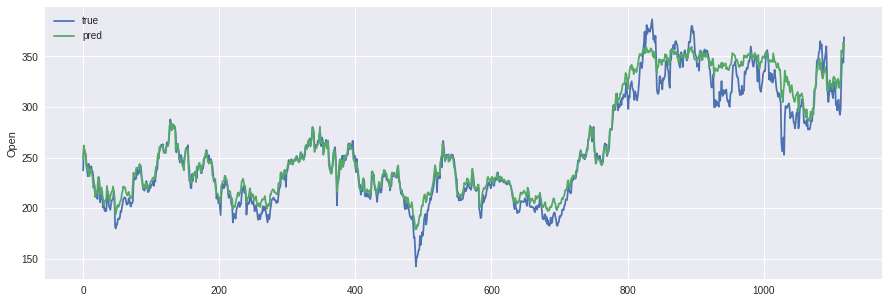

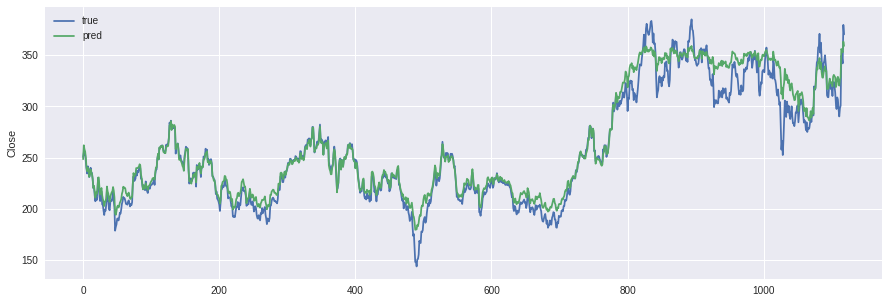

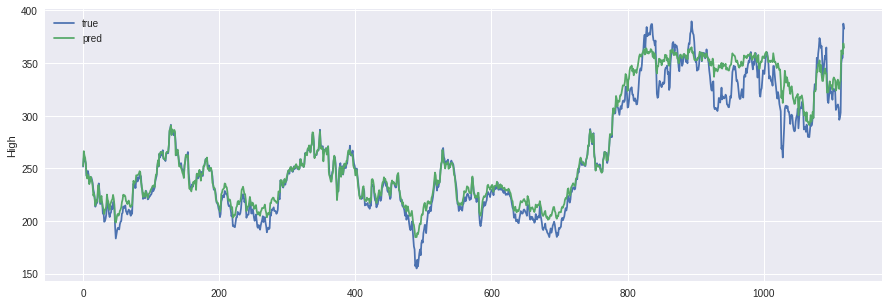

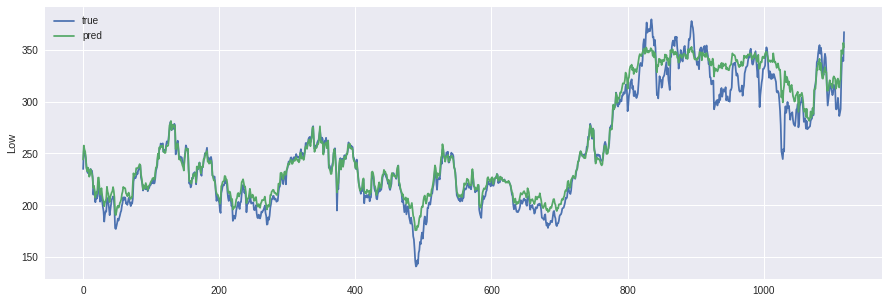

In [0]:
plot_comparison(start_idx=0, length=num_train, train=True)


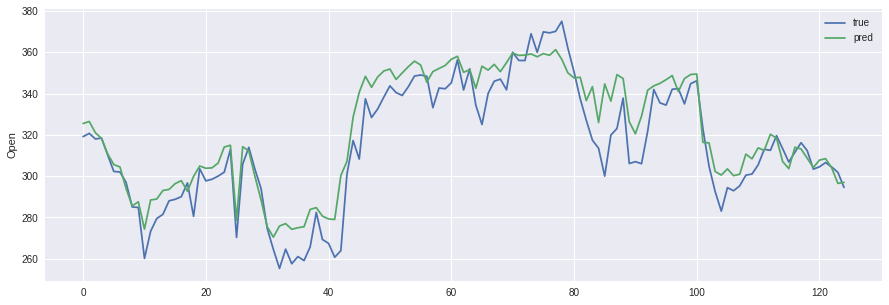

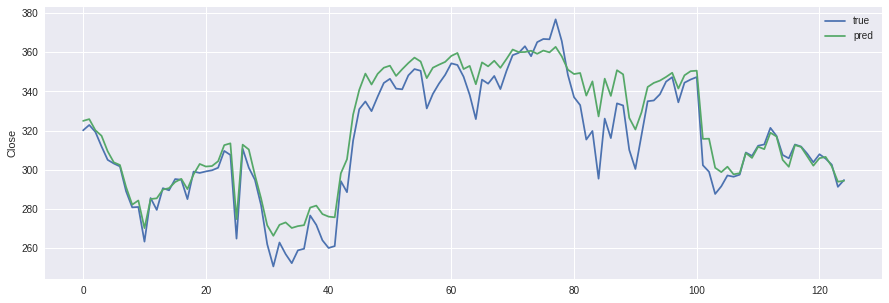

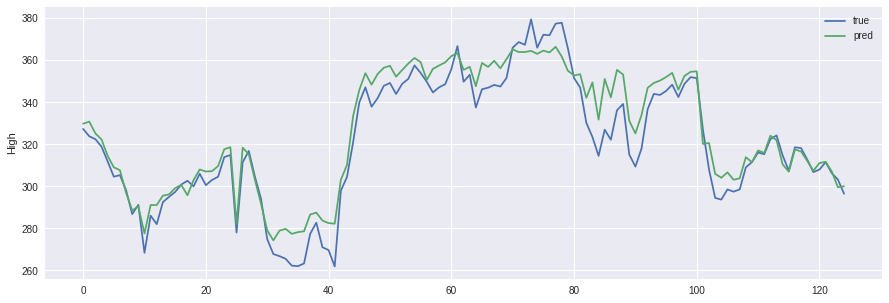

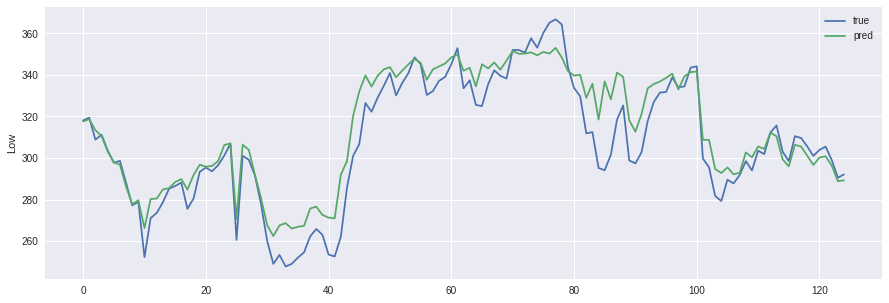

In [0]:
plot_comparison(start_idx=0, length=num_to_last, train=False)


# Inference

In [0]:
xx = pred_data_infer_scaled
data_scaler = infer_scaler

# Input-signals for the model.
xx = np.expand_dims(xx, axis=0)
# Use the model to predict the output-signals.
y_pred = model.predict(xx)

# The output of the model is between 0 and 1.
# Do an inverse map to get it back to the scale
# of the original data-set.
y_pred_rescaled = data_scaler.inverse_transform(y_pred[0])

# print(type(y_pred_rescaled))

# print(pred_data)
# print(y_pred_rescaled)

# # for dataframe format verification
# print(pred_df)
# print(y_pred_rescaled_t)

# for predicted data
# want to transpose to get all values in index of 
# 'Open','Close' etc and not by time
y_pred_rescaled_t =y_pred_rescaled.transpose()

date_num = np.arange(days_for_pred)
open_pred = y_pred_rescaled_t[0][:]
close_pred = y_pred_rescaled_t[1][:]
high_pred = y_pred_rescaled_t[2][:]
low_pred = y_pred_rescaled_t[3][:]
trace = go.Candlestick(x=date_num,
                open=open_pred,
                high=high_pred,
                low=low_pred,
                close=close_pred)
data = [trace]
py.iplot(data, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ozzy333/0 or inside your plot.ly account where it is named 'simple_candlestick'


In [0]:
# for actual input data
# want to transpose to get all values in index of 
# 'Open','Close' etc and not by time
input_data_t =pred_data.transpose()

open_input = input_data_t[0][:]
close_input = input_data_t[1][:]
high_input = input_data_t[2][:]
low_input = input_data_t[3][:]


trace = go.Candlestick(x=date_num,
                open=open_input,
                high=high_input,
                low=low_input,
                close=close_input)
data = [trace]
py.iplot(data, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ozzy333/0 or inside your plot.ly account where it is named 'simple_candlestick'


In [0]:
# # delete ALL saved things from training op 
# !rm -rf  check* graph* even* model* *logs #*png
# # and delete tensorboard history
# !rm -rf  ngrok*
# # see all files in directory
# !ls